In [1]:
!curl -o "data/bbc_text_cls.csv" "https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv" --ssl-revoke-best-effort

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 87 4965k   87 4334k    0     0  2539k      0  0:00:01  0:00:01 --:--:-- 2544k
100 4965k  100 4965k    0     0  2696k      0  0:00:01  0:00:01 --:--:-- 2701k


In [4]:
from transformers import pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

In [6]:
classifier = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [19]:
classifier("This is such a great moovie", candidate_labels=["Positive", "Negative"])

{'sequence': 'This is such a great moovie',
 'labels': ['Positive', 'Negative'],
 'scores': [0.9362872242927551, 0.0637127235531807]}

In [20]:
df = pd.read_csv("data/bbc_text_cls.csv")

In [26]:
len(df)

2225

In [27]:
df.sample(frac=1).head()

,text,labels
1683,All Black magic: New Zealand rugby\n\nPlaying ...,sport
1233,Lib Dems highlight problem debt\n\nPeople vuln...,politics
409,DaimlerChrysler's 2004 sales rise\n\nUS-German...,business
1001,Howard attacks cost of asylum\n\nMichael Howar...,politics
1346,"Athens memories soar above lows\n\nWell, it's ...",sport


In [29]:
labels = list(set(df["labels"]))
labels

['tech', 'entertainment', 'politics', 'business', 'sport']

In [33]:
print(textwrap.fill(df.iloc[1024]["text"]))

UK troops on Ivory Coast standby  Downing Street has confirmed British
troops are on standby in case they need to help evacuate several
hundred UK citizens from Ivory Coast.  The news came as it emerged
France had begun evacuating its hostages after days of anti-French
demonstrations. Trouble flared after nine French peacekeepers were
killed and President Jacques Chirac ordered the destruction of the
Ivory Coast's air force. A company of 100-120 UK troops is understood
to have been put on standby. They are ready to fly out and secure the
route from the embassy to the airport if called upon. Prime Minister
Tony Blair's official spokesman said: "There are British nationals in
Ivory Coast and as you can imagine we are making the usual contingency
plans in case the situation deteriorates further, but that's all I can
say at this stage."  He added the situation would be monitored
carefully in case evacuation became necessary. France has played a
lead role in international peacekeeping in Iv

In [37]:
print(textwrap.fill(df.iloc[1024]["labels"]))

politics


In [38]:
# Proviamo a classificarlo:
classifier(df.iloc[1024]["text"], candidate_labels=labels)

{'sequence': 'UK troops on Ivory Coast standby\n\nDowning Street has confirmed British troops are on standby in case they need to help evacuate several hundred UK citizens from Ivory Coast.\n\nThe news came as it emerged France had begun evacuating its hostages after days of anti-French demonstrations. Trouble flared after nine French peacekeepers were killed and President Jacques Chirac ordered the destruction of the Ivory Coast\'s air force. A company of 100-120 UK troops is understood to have been put on standby. They are ready to fly out and secure the route from the embassy to the airport if called upon. Prime Minister Tony Blair\'s official spokesman said: "There are British nationals in Ivory Coast and as you can imagine we are making the usual contingency plans in case the situation deteriorates further, but that\'s all I can say at this stage."\n\nHe added the situation would be monitored carefully in case evacuation became necessary. France has played a lead role in internati

In [39]:
preds = classifier(df["text"].to_list(), candidate_labels=labels)

In [41]:
predicted_labels = [p["labels"][0] for p in preds]

In [43]:
df["predicted_labels"] = predicted_labels

In [44]:
print(f"Simple Accuracy: {np.mean(df["labels"] == df["predicted_labels"])}")

Simple Accuracy: 0.5649438202247191


In [46]:
# Stiamo creando la matrice delle probabilità associate alle predizioni, però rispettando l'ordine iniziale delle labels

N = len(df)
K = len(labels)
# Creiamo una hashmap per le labels che mappa le labels agli indici.
label2index = {v:k for k, v in enumerate(labels)}
label2index

{'tech': 0, 'entertainment': 1, 'politics': 2, 'business': 3, 'sport': 4}

In [49]:
probs = np.zeros((N,K))
for i in range(N):
    pred = preds[i]
    for label, score in zip(pred["labels"], pred["scores"]):
        matrix_idx = label2index[label]
        probs[i, matrix_idx] = score

In [68]:
# Per calcolare L'AUC abbiamo bisogno delle labels come valori interi, dunque convertiamo le label del df in interi
# Servirà anche per la confusion matrix
# Sono i true values, ma convertiti in indici.
int_labels = [label2index[x] for x in df["labels"]]

In [69]:
# Prendiamo la probabilità massima per ogni predizione. Nota che qui già sono in ordine per costruzione di matrice
int_predictions =  np.argmax(probs, axis=1) 

In [70]:
cm = confusion_matrix(int_labels, int_predictions, normalize="true")

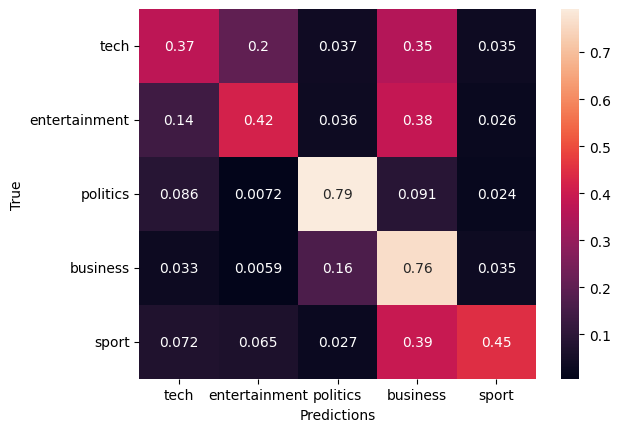

In [71]:
def plot_cm(cm):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    ax = sns.heatmap(df_cm, annot=True, fmt=".2g")
    ax.set_xlabel("Predictions")
    ax.set_ylabel("True")

plot_cm(cm)

In [65]:
# Questo score è naturalmente creato per classificazione binaria. Per poterlo usare in una classificazione multipla,
# è necessario passare average = "micro"  -> Calculate metrics globally by counting the total true positives, false negatives and false positives. [docs]
# Siccome F1 rispecchia l'accuratezza, significa che le classi non sono sbilanciate
f1_score(df["labels"], df["predicted_labels"], average="micro")

0.5649438202247191

In [73]:
# Multi-Class OVO = One-Versus-One.
# Anche questa metrica è naturalmente usata per una classificazione binaria, quindi abbiamo bisogno di specificare che è multi
# Le int labels ci serve per dire quale delle colonne della matrice probs corrispondano alla label
roc_auc_score(int_labels, probs, multi_class="ovo")

0.8853276109189723

In [ ]:
# ESERCIZIO:
# Provare ad usare uno zero-shot classifier per la sentiment analysis usando il dataset  "data/AirlineTweet.csv"